In [2011]:
from bs4 import BeautifulSoup
from urllib2 import urlopen
import requests
import pandas as pd
import numpy as np
import re
from dateutil.parser import parse
from random import randint
from time import sleep
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from __future__ import division
import collections
from collections import Counter
from sklearn import grid_search, decomposition
# To Plot matplotlib figures inline on the notebook
%matplotlib inline


#### making a function for making soup

In [4]:
def makesoup(link):
    response = requests.get(link)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup


#### This function reads boxofficemojo animated genre movie list and output it as a Pandas Dataframe

In [334]:
def mojotable(soup):
    table = soup('table')[3] #start looking into the actual table
#intialize a data frame with the right column headers
    last = len(table.findAll('tr')) -4
    ind = range(1, last)
    columns = []

    for i in table.findAll('tr')[0].findAll('td')[:]:
        columntitle = i.text.split('/')
        columns.extend(i.text.split('/'))

    columns = [re.sub(r'\([^)]*\)', '', i) for i in columns] 
    columns.append('Link')
    movie_df = pd.DataFrame(index = ind, columns = columns)
    movie_df.columns = movie_df.columns.str.strip()

    for i in ind:
        row_content = []
        link = BASE_URL + table.findAll('tr')[i].find('a')['href']
        for row in table.findAll('tr')[i].findAll('td')[:]:
            content = str(row.text).replace('$', '').replace(',', '')
            row_content.append(content)
        row_content.append(link)
        movie_df.loc[i] = row_content    

    movie_df = movie_df.replace('-', np.nan)
    movie_df = movie_df.replace('n/a', np.nan)
    movie_df['Rank'] = movie_df['Rank'].astype('float')
    movie_df['Adj. Gross'] = movie_df['Adj. Gross'].astype('float')
    movie_df['Opening'] = movie_df['Opening'].astype('float')

    movie_df.drop(['Theaters', 'Theaters', 'Row'], axis=1, inplace=True)
    return movie_df

#### Getting started with boxoffice mojo animated movie list, using 2016 adjusted grossing
* page is ranked by time of release (from newest to oldest)

In [335]:
BASE_URL = "http://www.boxofficemojo.com"
url = 'http://www.boxofficemojo.com/genres/chart/?id=animation.htm&sort=date&order=DESC&adjust_yr=2016&p=.htm'
adjuster = '&adjust_yr=2016&p=.htm' #add to end of boxofficemojo to adjust for 2016 ticket prices

soup = makesoup(url)
#the top grossing animated movie table is separated into 5 separate pages
#on the first page, grab the links for the other 4 pages
rankpgs = soup.findAll('b')[2].findAll('a')
ranklinks = []
for i in rankpgs:
    link = BASE_URL+i.attrs['href']
    ranklinks.append(link) 


mojo_df = mojotable(soup)


for link in ranklinks:

    soup = makesoup(link)
    df = mojotable(soup)
    mojo_df = pd.concat([mojo_df, df], ignore_index= True)

#### save dataframe to a csv file

mojo_df.to_csv('mojoanimatedrank.csv')

In [75]:
def numbers_table(soup, t):
    table = soup.find('table')

    header = table.findAll('tr')[0]
    columns = []
    content = table.findAll('tr')[1:-1]
    ind = range(1, len(content))

    for i in header.findAll('th')[:]:
        column_name = i.text.replace(' ', '')
        columns.append(column_name)

    columns.extend(['Link', 'Type'])
    movie_df = pd.DataFrame(index = ind, columns = columns)

    for i in ind:
        row_content = []
        link = BASE_URL + table.findAll('tr')[i].find('a')['href']
        for row in table.findAll('tr')[i].findAll('td')[:]:
            content = row.text.encode('ascii', 'replace')
            row_content.append(content)
        row_content.append(link)
        row_content.append(t)
        row_content[4] = row_content[4].replace('$', '').replace(',', '')
        row_content[5] = row_content[5].replace('$', '').replace(',', '')
        movie_df.loc[i] = row_content    

    movie_df['ReleaseDate'] = movie_df['ReleaseDate'].apply(parse)
    movie_df['TotalGross'] = movie_df['TotalGross'].astype('float')
    movie_df['Inflation-AdjustedGross'] = movie_df['Inflation-AdjustedGross'].astype('float')
    
    return movie_df

In [643]:
#since when we save the table as a csv file, the list of names were saved as an entire string
#this function just cleans the large string up and back into a list of names
def cleanname(name_string):
    new_list = []
    first_pass = name_string.strip('[\\\'').strip('\\\']').split(',')
    for i in first_pass:
        new_list.append(i.strip().strip("'").strip('"'))
    
    return new_list
#function to compute geometric mean of a np array
def gmean (arr):
    return np.power(np.prod(arr), 1/len(arr))

In [2774]:
#Define functions used to get scores and rankings
def getscores(nl):
    score = []
    for i, name in enumerate(nl):
        if name and not np.isnan(actor[name]):
            score.append(float(actor[name]))
            #print name, actor[name]
            #print actorlinks[name]
        else:
            score.append(70000)
    #print zip(namebymovie[100], score)
    score = np.array(score)
    return score



def getSrank(i, nl, dictionary):
    score = 0.0
    for n, name in enumerate(nl):
        if name in dictionary.keys():
            years = dictionary[name]
            ryears = new_df['ReleaseYear'][i]
            for j in years:
                if j == ryears or j == ryears-1:
                    score +=1.0
                elif j<ryears-1:
                    score = score + 1.0/(ryears-j)
                else:
                    score = score
    return score#/len(nl)

#### Using The Numbers Dataset instead

In [76]:
BASE_URL = "http://www.the-numbers.com/"
url = 'http://www.the-numbers.com/movies/production-method/'
types = ['Stop-Motion-Animation', 'Digital-Animation', 'Hand-Animation']



In [79]:
j = 0
for i in types:
    new_url = url + i
    print new_url
    soup = makesoup(new_url)
    if j ==0:
        movie_df = numbers_table(soup, i)
    else:
        df = numbers_table(soup, i)
        movie_df = pd.concat([movie_df, df], ignore_index= True)
    j+=1

http://www.the-numbers.com/movies/production-method/Stop-Motion-Animation
http://www.the-numbers.com/movies/production-method/Digital-Animation
http://www.the-numbers.com/movies/production-method/Hand-Animation


In [84]:
new_df = movie_df[movie_df['TotalGross'] != 0]

#### Now that we have the dataframe, start looking at data for each movie

In [86]:
new_df
new_df.to_csv('numbersanimatedrank.csv')

#### want to add the following parameters, have to obtained by scraping individual pages:
* source (original, fairytale, book)
* franchise (1 or 0)
* top 5 grossing actors (get their ranking from actors' pages)
* production countries



In [368]:
new_df['Source'] = ''
new_df['Franchise'] = ''
new_df['Production Countries']= ''
new_df['Actors'] = ''
new_df['Budget'] = ''
new_df['Studio'] = ''
   
rank = re.compile('\(rank #(\d*?,?\d*?)\)')
actor ={}
actorlinks = {}


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [388]:
lookfor = ['Source', 'Franchise', 'Production Countries','Budget', 'Studio']
for i in new_df.index[36:]:
    sleep(randint(1,5))
    current = new_df['Link'][i]
    current_cc = current.replace('#tab=summary', '#tab=cast-and-crew')
    #finds source, fanchise, and production country info in summary tab
    movie_page = makesoup(current)

    for j in lookfor:
        
        if j == 'Franchise':
            a = movie_page.find('td', text = re.compile(j))
            if str(a) != 'None':
                a = 1
            else:
                a = 0
        elif j == 'Production Countries':
            a = movie_page.find('td', text = re.compile(j))
            if str(a) != 'None':
                a = a.nextSibling.nextSibling.text
        elif j == 'Source':
            a = movie_page.find('td', text = re.compile(j))
            if str(a) != 'None':
                a = a.nextSibling.text
        elif j == 'Budget':
            a = movie_page.find('td', text = re.compile('Production\xa0Budget:') )
            if str(a) != 'None':
                a = a.nextSibling.text
                a = int(a.replace('$', '').replace(',', ''))
            else:
                a = np.nan
        elif j == 'Studio': 
            a = movie_page.find('td', text = re.compile('Domestic Releases:'))
            if str(a) != 'None':
                a = a.nextSibling.nextSibling.a
                if str(a) != 'None':
                    a = a.text
                else:
                    a = 'Unknown'
            else:
                a = 'Unknown'
        new_df[j][i] = a


 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
73
74
75
76
77
78
79
80
81
82
83
84
85
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
121
123
124
125
126
127
128
129
130
131
132
133
134
135
137
138
139
140
141
142
143
144
146
147
148
151
152
153
154
155
156
158
161
163
164
165
166
167
168
169
172
173
175
176
177
178
179
181
182
183
184
186
187
188
189
191
192
193
194
195
196
198
243
244
245
247
249
250
251
252
253
254
255
256
257
258
259
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
357
358
359
360
361
362
363
364
365
366
368
369
370
371
372
3

In [919]:
acting = re.compile('\w* ?Act\w*')
rank = re.compile('\(rank #(\d*?,?\d*?)\)')
#actor ={}
#actorlinks = {}
#other = {}
for i in new_df.index:
    #sleep(randint(1,5))
    current = new_df['Link'][i]
    current_cc = current.replace('#tab=summary', '#tab=cast-and-crew')
    #finds source, fanchise, and production country info in summary tab
    movie_cc = makesoup(current_cc)
    people = []
    if str(movie_cc.find('div', id = 'cast')) != 'None':
        actorlink = movie_cc.find('div', id = 'cast').findAll('a')
        for k in actorlink:
            
            name = k.text.encode('ascii', 'replace')
            person = BASE_URL+k['href']
            people.append(name)
            if name not in actor.keys():
                sleep(1+np.random.rand())
                personpage = makesoup(person)
                ranking = re.findall(rank, personpage.find('td').text)[0]
                ranking = int(ranking.replace(',', ''))
                #keep separate records of people's rankings depending on their job
                if re.match(acting, personpage.find('b').text)!=None:
                    actor[name] = ranking
                else:
                    actor[name] = np.nan
                    other[name] = ranking
                actorlinks[name] = person
    new_df['Actors'][i] = people
    print i

0
1
2
3
4
5


In [599]:
import cPickle as pickle
pickle.dump(actor, open( "actor_ranking.p", "wb" ) )
pickle.dump(other, open('other_ranking.p', 'wb'))
pickle.dump(actorlinks, open('actor_links.p', 'wb'))

In [676]:
new_df['ReleaseDate'] = new_df['ReleaseDate'].apply(parse)
new_df['TotalGross'] = new_df['TotalGross'].astype('float')
new_df['Inflation-AdjustedGross'] = new_df['Inflation-AdjustedGross'].astype('float')
new_df #now has the info i think are relevant

,Unnamed: 0,Movie,ReleaseDate,Genre,MPAARating,TotalGross,Inflation-AdjustedGross,Link,Type,Source,Franchise,Production Countries,Actors,Budget,Studio
0,1,The Nightmare Before Christmas,1993-10-13,Musical,PG,50408318.0,100026637.0,http://www.the-numbers.com//movie/Nightmare-Be...,Stop-Motion-Animation,Original Screenplay,0,United States,"['Chris Sarandon', ""Catherine O'Hara"", 'Paul R...",NaN,Walt Disney
1,3,Wallace & Gromit,1996-04-06,Adventure,Not Rated,1002002.0,1908063.0,http://www.the-numbers.com//movie/Wallace-and-...,Stop-Motion-Animation,Compilation,1,United Kingdom,['Nick Park'],NaN,Northern Arts Entertainment
2,4,James and the Giant Peach,1996-04-12,Adventure,PG,28921264.0,55159783.0,http://www.the-numbers.com//movie/James-and-th...,Stop-Motion-Animation,Based on Fiction Book/Short Story,0,United Kingdom,"['Pete Postlethwaite', 'Richard Dreyfuss', 'Su...",NaN,Walt Disney
3,5,Chicken Run,2000-06-21,Adventure,G,106793915.0,167026473.0,http://www.the-numbers.com//movie/Chicken-Run#...,Stop-Motion-Animation,Original Screenplay,0,United States,"['Phil Daniels', 'Lynn Ferguson', 'Mel Gibson'...",42000000.0,Dreamworks SKG
4,6,The Corpse Bride,2005-09-16,Adventure,PG,53359111.0,70174304.0,http://www.the-numbers.com//movie/Corpse-Bride...,Stop-Motion-Animation,Based on Folk Tale/Legend/Fairytale,0,United States,"['Johnny Depp', 'Helena Bonham Carter', 'Emily...",30000000.0,Laika
5,7,Wallace & Gromit: The Curse of the Were-Rabbit,2005-10-05,Adventure,G,56068547.0,73736182.0,http://www.the-numbers.com//movie/Wallace-and-...,Stop-Motion-Animation,Original Screenplay,1,United States,"['Peter Sallis', 'Ralph Fiennes', 'Helena Bonh...",30000000.0,Dreamworks SKG
6,9,Tim Burton's The Nightmare Before Christmas 3D,2006-10-20,Musical,PG,24732041.0,30737517.0,http://www.the-numbers.com//movie/Tim-Burtons-...,Stop-Motion-Animation,Original Screenplay,0,NaN,['William Hickey'],NaN,Walt Disney
7,10,$9.99,2008-12-12,Comedy,R,52107.0,58555.0,http://www.the-numbers.com//movie/9-99#tab=sum...,Stop-Motion-Animation,Based on Fiction Book/Short Story,0,NaN,"['Geoffrey Rush', 'Anthony LaPaglia', 'Joel Ed...",NaN,Regent Releasing
8,11,Coraline,2009-02-06,Adventure,PG,75286229.0,84621714.0,http://www.the-numbers.com//movie/Coraline#tab...,Stop-Motion-Animation,Based on Fiction Book/Short Story,0,United States,"['Dakota Fanning', 'Teri Hatcher', 'Jennifer S...",60000000.0,Laika
9,12,The Fantastic Mr. Fox,2009-11-13,Adventure,PG,21002919.0,23502848.0,http://www.the-numbers.com//movie/Fantastic-Mr...,Stop-Motion-Animation,Based on Fiction Book/Short Story,0,United States,"['George Clooney', 'Meryl Streep', 'Jason Schw...",40000000.0,20th Century Fox


##### Taking a look at how type of animation influences both budget and box office

<function matplotlib.pyplot.hold>

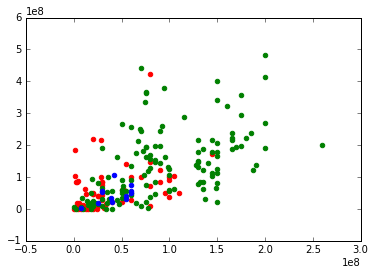

In [685]:
plt.scatter(new_df[new_df['Type']=='Hand-Animation']['Budget'], new_df[new_df['Type']=='Hand-Animation']['TotalGross'], color = 'r')
plt.hold
plt.scatter(new_df[new_df['Type']=='Digital-Animation']['Budget'], new_df[new_df['Type']=='Digital-Animation']['TotalGross'], color = 'g', marker = 'o')
plt.scatter(new_df[new_df['Type']=='Stop-Motion-Animation']['Budget'], new_df[new_df['Type']=='Stop-Motion-Animation']['TotalGross'], color = 'b')
plt.hold

In [ ]:
color = ['r', 'b', 'y']
j = 0
for i in set(new_df['Type']):
    df = new_df[new_df['Type']==i]
    plt.plot(df['ReleaseDate'], df['TotalGross'], 'o', color = color[j], label = i)
    j+=1
    plt.hold(True)
plt.legend(loc = 'best')

In [1013]:
#Take only the top ten listed actors for each movie
#Actors are listed as they are on top billing, so should reflect the importance of their role
#I checked this mannually for a few movies and this seems to be the case
namelist = [cleanname(i) for i in new_df['Actors']]

namebymovie = []
for i in namelist:
    if len(i) > 10:
        n = i[:10]
    else:
        n = i
    namebymovie.append(n)

new_df['TopActors']= namebymovie

In [1014]:
new_df.to_csv('animated_df_v1.csv')

#### Making a vultureDict, simpsonsDict, and snlDict
* vultureDict is a set of all names that has appeared in Vulture's most valuable stars list
* simpsonsDict is a dictionary of actor names and the number of times they have appeared
* snlDict is a dictionary of actor names and the number of times they have appeared

In [1344]:
###Making a dictionary for SNL and Simpsons
###Format of the Dictionary: {name: year of the episode they were guest acting/hosting in}
simpsonslink = 'https://en.wikipedia.org/wiki/List_of_The_Simpsons_guest_stars'
simpsonsYears = range(1990, 2016)
sou= makesoup(simpsonslink)

snames = [i.text.encode('ascii', 'replace') for i in sou.findAll('span', class_ = 'fn')[:920]]
seasons = [int(link.previousSibling.previousSibling.text) for link in sou.findAll('th', scope = 'row')[:920]]

simpsonsDict = collections.defaultdict(list)
for i, name in enumerate(snames):
    syear = simpsonsYears[seasons[i]-1]
    simpsonsDict[name].append(syear)
    

In [1346]:
year = re.compile('([1-2]\d\d\d)')
snlDict = collections.defaultdict(list)
snllink = 'https://en.wikipedia.org/wiki/List_of_Saturday_Night_Live_episodes'
soup = makesoup(snllink)

tables = soup.findAll('table', class_="wikitable plainrowheaders wikiepisodetable")
tables = tables[:-1]

for i in tables:
    subtable = i.findAll('td', class_ = 'summary')
    for j in subtable:
        name = j.text.encode('ascii', 'replace')
        date = j.nextSibling.nextSibling.nextSibling.nextSibling.text
        date = int(re.findall(year, date)[0])
        snlDict[name].append(date)

In [2776]:
#instead of top ten actors in each movie, get ranking for top ten actors for each movie
rank_by_movie = []
simpsons_score = []
snl_score = []
for i, names in enumerate(namebymovie):
    scores = getscores(names)
    simpsons = getSrank(i, names, simpsonsDict)
    snl = getSrank(i, names, snlDict)
    
    rank_by_movie.append(np.array(scores))
    simpsons_score.append(simpsons)
    snl_score.append(snl)


#Find the number of actors who belong to the top 1000 earnings list
Below1k = []
Below5k = []
for movie in rank_by_movie:
    above5k = 0
    below5k = 0
    below1k = 0
    for i in movie:#Top 1000 ranking
        if i < 1000:
            below1k+=1
        elif i<5000: #between 1000 and 5000 ranking
            below5k+=1 
    Below1k.append(below1k)
    Below5k.append(below5k)

0
0
0
0
1
0
0
0
0
4
0
0
0
1
0
0
0
0
0
0
2
1
0
0
1
0
0
1
1
0
0
0
0
0
0
1
2
0
1
0
2
0
0
1
0
0
0
2
1
1
2
1
0
0
1
0
2
2
0
1
0
0
2
0
2
0
1
0
0
0
0
0
0
3
1
0
0
0
0
0
0
2
0
0
0
3
1
0
1
0
0
0
0
1
2
1
3
0
1
2
1
3
0
0
1
4
0
3
1
0
3
0
1
1
1
2
1
1
1
3
0
0
2
2
0
0
2
0
0
1
1
2
1
0
0
1
0
0
2
4
0
2
0
4
0
0
0
2
0
1
0
0
0
0
2
0
2
1
0
0
0
0
1
4
2
0
1
1
1
1
0
0
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
1
1
1
0
0
0
0
0
0
1
0
0
1
0
1
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0


In [2695]:
#get just the release year
new_df['ReleaseYear'] = [i.year for i in new_df['ReleaseDate']]

In [1366]:
#Create test_df, which is where I add some of the newly engineered features
#new_df has all the scraped features

test_df = pd.concat([new_df['ReleaseYear'], new_df['Movie']], axis=1, keys=['ReleaseYear', 'Movie'])
test_df['1k'] = Below1k
test_df['TotalGross'] = new_df['TotalGross']
test_df['5k'] = Below5k
test_df['TopActors'] = new_df['TopActors']
test_df['simpson_score']=simpsons_score
test_df['snl_score'] = snl_score

test_df.to_pickle('test_df.p')
new_df.to_pickle('new_df.p')

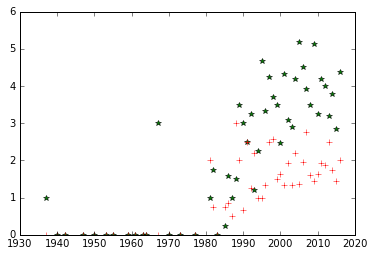

In [1368]:
b =test_df.groupby(['ReleaseYear'], as_index=False)['1k', 'TotalGross', '5k'].mean()

#Confirming the trend of increasing number of famous actors in animated films in recent years

plt.plot(b['ReleaseYear'], b['1k'], 'g*')
plt.plot(b['ReleaseYear'], b['5k'], 'r+')

In [1348]:
pickle.dump(vultureDict, open( "vultureDict.p", "wb" ) )
pickle.dump(simpsonsDict, open('simpsonsDict.p', 'wb'))
pickle.dump(snlDict, open('snlDict.p', 'wb'))

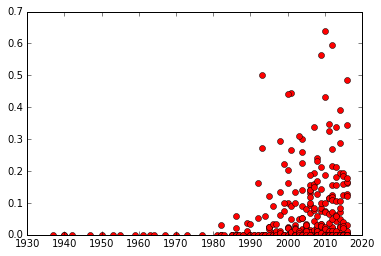

In [1480]:
plt.plot(new_df['ReleaseYear'], snl_score,  'ro')

In [1558]:
#If the studio has produced fewer than 4 movies, count all of them as "Other" in the studio category
a = new_df['Studio'].value_counts()
a = a>=4
a = dict(a)

new_studio = []
for i in new_df['Studio']:
    if a[i]:
        new_studio.append(i)
    else:
        new_studio.append('Other')
        

test_df['Studio'] = new_studio

In [1565]:
#similarly, if the country has produced fewer than 7 movies, group them as "Other Countries"
a = new_df['Production Countries'].value_counts()
a = a>=7
a = dict(a)
new_countries = []
for i in new_df['Production Countries']:
    i = str(i) 
    if i == 'nan':
        new_countries.append('Other Countries')
    elif a[i]:
        new_countries.append(i)
    else:
        new_countries.append('Other Countries')

new_df['new_countries'] = new_countries

In [1567]:
#Making dummy variables out of categorical variables 

Ratings = pd.get_dummies(new_df['MPAARating'])
Type = pd.get_dummies(new_df['Type'])
countries = pd.get_dummies(new_df['new_countries'])
test_df = test_df.drop('Studio', axis = 1 )
test_df = test_df.drop('Movie', axis = 1)

In [1505]:
test_df = pd.concat([test_df, Ratings], axis = 1)

test_df = pd.concat([test_df, Type], axis = 1)

test_df= pd.concat([test_df, sdummy], axis = 1)

In [1573]:
test_df = pd.concat([test_df, countries], axis = 1)

In [1529]:
test_df['Franchise'] = new_df['Franchise']

In [1533]:
#Find out how many rows has missing 'Budget' data
for i in new_df.columns:
    print i, (new_df[i].isnull().sum())/len(new_df)

Movie 0.0
ReleaseDate 0.0
Genre 0.0
MPAARating 0.0835820895522
TotalGross 0.0
Inflation-AdjustedGross 0.0
Link 0.0
Type 0.0
Source 0.0179104477612
Franchise 0.0
Production Countries 0.173134328358
Actors 0.0
Budget 0.388059701493
Studio 0.0
TopActors 0.0
ActorRanking_geometric 0.0089552238806
ActorRanking_avg 0.0
ReleaseYear 0.0


In [1673]:
#use this chunk of code to fill in the empty entries in Budget
X = pd.concat([new_df['TotalGross'], test_df['Walt Disney']], axis = 1)
X = pd.concat([X, test_df['ReleaseYear']], axis = 1)

y = new_df['Budget']
X['Intercept']=np.ones(len(X))
y_train=y[y.isnull()==False]
# what we're trying to predict
y_test=y[y.isnull()==True]

x_train=X[y.isnull()==False]
x_test=X[y.isnull()==True]

X2 = pd.concat([X, y], axis = 1)
import statsmodels.formula.api as sm
model = sm.OLS(y_train,x_train )
results = model.fit()

for i in y_test.index:
    X2.Budget.loc[i]=abs(results.predict(x_test.loc[i]))

test_df['Budget'] = X2['Budget']

### Start Actually Modeling

In [1974]:
#Making the X and Y variable
X,y = test_df.drop('TotalGross', axis=1),test_df['TotalGross']

In [1679]:
from sklearn import cross_validation, datasets
from sklearn import linear_model
from __future__ import division

In [2420]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
                                        X, y, test_size=0.3)

### Random Forest with CROSS VALIDATION

using only movies made since 1980

In [2938]:
X85 = X[test_df['ReleaseYear']>= 1980]
y85 = y[test_df['ReleaseYear']>= 1980]

In [2883]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
                                        X85, y85, test_size=0.3)

In [2917]:
RandomF = RandomForestRegressor()
shuffler = cross_validation.KFold(len(X_train), n_folds= 3, shuffle = True)
parameters = {'n_estimators': range(10, 51, 10), 
              'min_samples_leaf': range(1, 11),
              'max_features': range(5, 21, 5),
              'max_depth': range(1, 11), 
              'min_samples_split': range(2, 21, 2)}
grid_searcher85 = grid_search.GridSearchCV(RandomF, parameters, n_jobs= 3, cv=shuffler)
grid_searcher85.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=223, n_folds=3, shuffle=True, random_state=None),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_estimators': [10, 20, 30, 40, 50], 'max_features': [5, 10, 15, 20], 'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [ ]:
bestmodel85 = grid_searcher85.best_estimator_
shuffler = cross_validation.KFold(len(X85), n_folds= 5, shuffle = True)
#bestmodel85.estimator_params()
print cross_validation.cross_val_score(bestmodel85, X85, y85, cv = shuffler)
print bestmodel85.score(X_test, y_test)
zip(X85.columns, bestmodel85.feature_importances_)
guess_train = bestmodel85.predict(X_train)
guess_test = bestmodel85.predict(X_test)
plt.scatter(guess_train, y_train, label = 'train')
plt.scatter(guess_test, y_test, color = 'r', label = 'test')
plt.legend(loc = 'upper left')
print grid_searcher85.best_params_
sorted_features = sorted(zip(X85.columns,bestmodel85.feature_importances_), key=lambda tup: abs(tup[1]), reverse=True)
for feature in sorted_features:
    print(feature)

#plt.bar(range(len(sorted_features)), sorted_features[:][1])
features = [i[0] for i in sorted_features]
importance = [i[1] for i in sorted_features]
#plt.bar(range(len(features)), importance)

fig = plt.figure(dpi = 400, figsize = (12, 8))
ax  = fig.add_subplot(111)
plt.bar(range(len(features)), importance)
ax.set_ylabel('Feature Importance', fontsize = 14)
ax.set_xlabel('Features', fontsize = 16)
#ax.set_xticklabels(features, size = 'medium', rotation = 90)
#ax.set_yticklabels(range(0, 7), size = 'medium');

### Linear Regression (of rate of return, after 1980)

In [2910]:
y_yield = np.log((1.0*y)/X['Budget'])
X_new = X.drop('Budget', axis = 1)
X_new = X_new.drop('5k', axis = 1)
X85 = X_new[test_df['ReleaseYear']>= 1980]
y85 = y_yield[test_df['ReleaseYear']>= 1980]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
                                        X85, y85, test_size=0.3)


Lasso = linear_model.Lasso(alpha=0.025)
feature_names = X85.columns

In [2916]:
Lasso.fit(X_train,y_train)
shuffler = cross_validation.KFold(len(X85), n_folds= 5, shuffle = True)
#bestmodel85.estimator_params()
print cross_validation.cross_val_score(Lasso, X85, y85, cv = shuffler)

print("Score: " + str(Lasso.score(X_test,y_test)))
sorted_features = sorted(zip(feature_names,Lasso.coef_), key=lambda tup: abs(tup[1]), reverse=True)
for feature in sorted_features:
    print(feature)

[ 0.60915751  0.5132597   0.60000882  0.58661874  0.66859127]
Score: 0.6240168685
('Not Rated', -1.8785782954649435)
('GKIDS', -1.7385040256775044)
('Other', -1.7090301755466999)
('United States', 0.78750380947838605)
('Franchise', 0.69009882183085514)
('1k', 0.21545085795755667)
('Hand-Animation', -0.19910997035620848)
('v_score', 0.13435773764922937)
('ReleaseYear', -0.095512861877816671)
('PG', 0.074177747196713731)
('Lionsgate', 0.067690213381978906)
('Digital-Animation', 0.054766194702722946)
('simpson_score', 0.053534235505237879)
('Walt Disney', 0.053049023709708987)
('Miramax', -0.029251205662710288)
('snl_score', 0.0)
('G', 0.0)
('PG-13', -0.0)
('R', -0.0)
('Stop-Motion-Animation', 0.0)
('20th Century Fox', 0.0)
('Atlantic', 0.0)
('Dreamworks SKG', -0.0)
('Eleven Arts', -0.0)
('Laika', 0.0)
('MGM', -0.0)
('Paramount Pictures', 0.0)
('Sony Pictures', -0.0)
('Sony Pictures Classics', 0.0)
('Universal', 0.0)
('Warner Bros.', 0.0)
('Weinstein Co.', -0.0)
('Japan', -0.0)
('Other Co

In [2920]:
sorted_features_trim = []
for i, j in sorted_features:
    if abs(j) > 0.01:
        sorted_features_trim.append(i)

In [2921]:
sorted_features_trim

['Not Rated',
 'ReleaseYear',
 'Other',
 '1k',
 'United States',
 'snl_score',
 'simpson_score',
 'Japan',
 'GKIDS',
 'Other Countries',
 'Franchise',
 'Hand-Animation',
 'PG-13']

In [2927]:
X_OLS = pd.concat([X85['Not Rated'], X85['ReleaseYear']], axis = 1)

In [2928]:
for i in sorted_features_trim[2:]:
    X_OLS = pd.concat([X_OLS, X85[i]], axis = 1)

X_OLS

,Not Rated,ReleaseYear,Other,1k,United States,snl_score,simpson_score,Japan,GKIDS,Other Countries,Franchise,Hand-Animation,PG-13
0,0.0,1993,0.0,2,1.0,0.500000,0.000000,0.0,0.0,0.0,0,0.0,0.0
1,1.0,1996,1.0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,1,0.0,0.0
2,0.0,1996,0.0,4,0.0,0.006944,1.000000,0.0,0.0,0.0,0,0.0,0.0
3,0.0,2000,0.0,4,1.0,0.023377,1.000000,0.0,0.0,0.0,0,0.0,0.0
4,0.0,2005,0.0,6,1.0,0.003704,0.071429,0.0,0.0,0.0,0,0.0,0.0
5,0.0,2005,0.0,4,1.0,0.000000,0.000000,0.0,0.0,0.0,1,0.0,0.0
6,0.0,2006,0.0,0,0.0,0.000000,0.000000,0.0,0.0,1.0,0,0.0,0.0
7,0.0,2008,1.0,2,0.0,0.000000,0.000000,0.0,0.0,1.0,0,0.0,0.0
8,0.0,2009,0.0,5,1.0,0.009615,0.000000,0.0,0.0,0.0,0,0.0,0.0
9,0.0,2009,0.0,6,1.0,0.035081,0.154762,0.0,0.0,0.0,0,0.0,0.0


In [2929]:
import statsmodels.api as sm

In [ ]:
model = sm.OLS(y85, X85)
results = model.fit()

results.summary()